In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from plotting_helper import * 

from brian2 import *
from brian2tools import *


figures_path = 'figures/'
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

/home/patricia/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [25]:
#bars and stripes
start_scope()

seed(42)

N_stim = 10
baseline = 5
on_rate = 100

#poisson input
IG = NeuronGroup(N_stim*N_stim, 'rates : Hz', threshold='rand()<rates*dt', refractory = 3 * ms)


@network_operation(dt=50*ms)
def stripes_bars(t):
    N = N_stim
    pattern = np.zeros((N,N))
    pattern[np.random.randint(0,N),:] = 1
    pattern[:,np.random.randint(0,N)] = 1
    new_rates = pattern.flatten()* on_rate * Hz
    IG.rates=new_rates

spike_monitor_IG = SpikeMonitor(IG)
run(150 *ms)

In [26]:
vdp_w = np.load('simulation_results/bars_and_stripes_W_vdp.npy')

mb_w = np.load('simulation_results/bars_and_stripes_W_meissnerbernard.npy')

cl_w = np.load('simulation_results/bars_and_stripes_W_clopath.npy')

In [27]:
from sklearn.metrics.pairwise import cosine_similarity

stimulis = np.zeros([N_stim*2,N_stim**2])
for i in range(N_stim):
    stim = np.zeros([N_stim,N_stim])
    stim[i,:] = 1
    stimulis[i,:] = stim.flatten() 
    stim = np.zeros([N_stim,N_stim])
    stim[:,i] = 1
    stimulis[i+N_stim,:] = stim.flatten() 
    
def ICA_score(weights, stims): 
    I_s = np.zeros([weights.shape[1]])
    zero_weights = 0
    ceiled_weights = 0
    mean_tot = np.mean(weights)
    for ind in range(weights.shape[1]):
        rf = weights[:,ind] * (weights[:,ind]> mean_tot)
        #rf = weights[:,ind]
        if np.mean(rf) < (mean_tot/3): 
            zero_weights +=1
        if np.mean(rf) > (1.8): 
            ceiled_weights +=1
        I_s[ind] = np.max(cosine_similarity(rf.reshape(1,-1),stims))
        
    np_Is = np.sum((I_s > 0.95) * (I_s < 1.05))
        
    return I_s, np_Is, zero_weights, ceiled_weights

In [28]:
vdp_scores = ICA_score(vdp_w, stimulis)

cl_scores = ICA_score(cl_w, stimulis)

mb_scores = ICA_score(mb_w, stimulis)

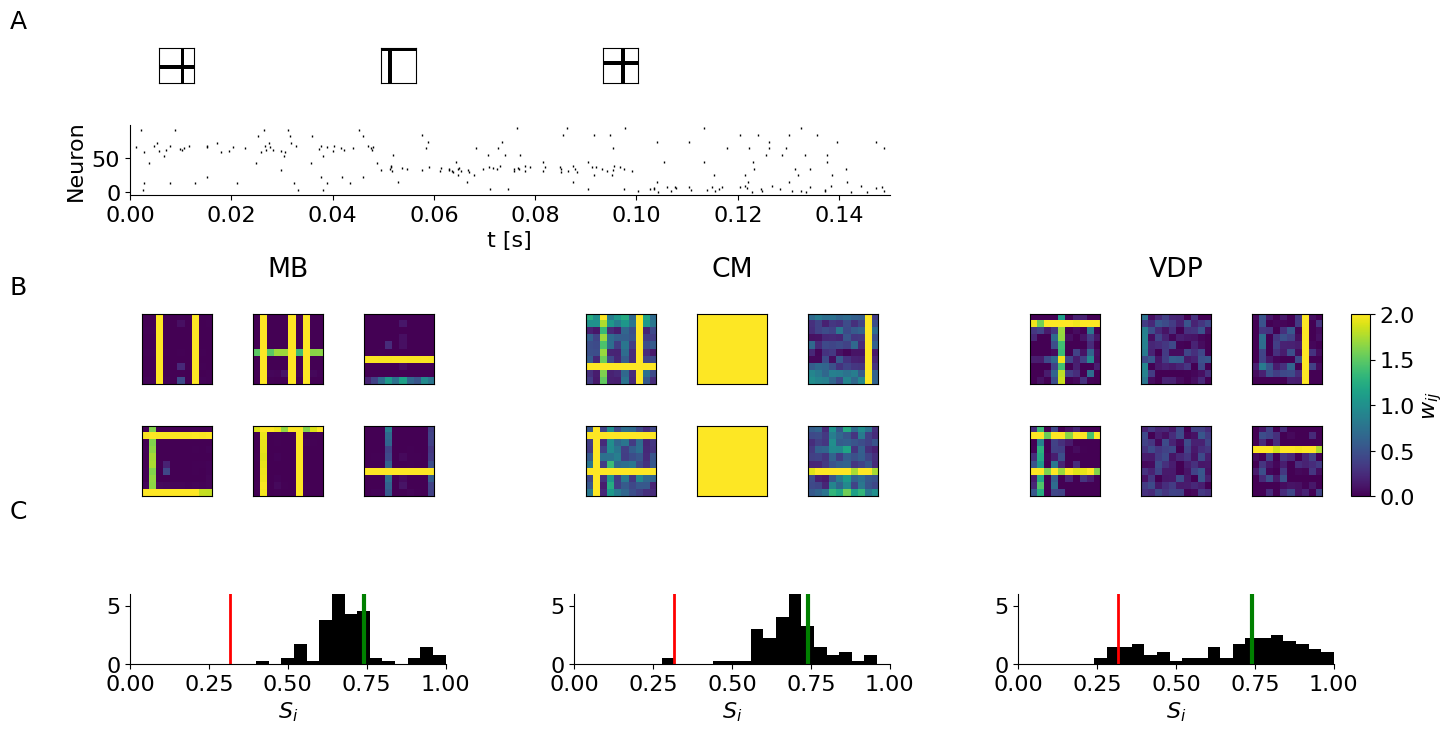

In [29]:
 #Do the figure

layout = '''
    AAAAAAAAAAAA
    AAAAAAAAAAAA
    AAAAAAAAAAAA
    BBBBBBBBBBBB
    BBBBBBBBBBBB
    CCCCCCCCCCCC
    CCCCCCCCCCCC
    '''

fig = plt.figure(figsize=(16, 8))

height_ratios = [0.5,1,0.5,1,1,0.2,1]
width_ratios = [1,1,1,1,1,1,1,1,1,1,1,0.2]

specs, gs = panel_specs(layout, fig=fig)
gs.set_height_ratios(height_ratios)
gs.set_width_ratios(width_ratios)
gs.hspace=0.8
axes = {}
for letter in 'ABC':
    axes[letter] = ax = fig.add_subplot(specs[letter])
label_panels(axes, letters='ABC', postfix='', offset_left=1.2)
for a in list('ABC'):
    axes[a].set_axis_off()

    
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

#plot bars and stripes example image
ax = fig.add_subplot(gs[0,0])
input_pattern = np.zeros([N_stim,N_stim])
input_pattern[4,:] = 1.0
input_pattern[:,6] = 1.0
ax.imshow(input_pattern, origin = 'lower', cmap = 'Greys', vmin = 0, vmax = 1)
ax.set_xticks(())
ax.set_yticks(())

ax = fig.add_subplot(gs[0,2])
input_pattern = np.zeros([N_stim,N_stim])
input_pattern[9,:] = 1.0
input_pattern[:,2] = 1.0
ax.imshow(input_pattern,  origin = 'lower',cmap = 'Greys', vmin = 0, vmax = 1)
ax.set_xticks(())
ax.set_yticks(())

ax = fig.add_subplot(gs[0,4])
input_pattern = np.zeros([N_stim,N_stim])
input_pattern[5,:] = 1.0
input_pattern[:,5] = 1.0
ax.imshow(input_pattern,  origin = 'lower',cmap = 'Greys', vmin = 0, vmax = 1)
ax.set_xticks(())
ax.set_yticks(())

#plot the bars and stripes spikes
ax = fig.add_subplot(gs[1,0:7])
plt.plot(spike_monitor_IG.t / second, spike_monitor_IG.i , "|", color='k', ms=1)
ax.set_xlabel('t [s]')
ax.set_ylabel('Neuron')
ax.set_xlim(0,0.15)
clear_axes(ax)

#plot the receptive fields , example cells of the different models
minw = 0#np.min(mb_w)
maxw = 2#np.max(mb_w)
example_mb = [0,9,41,1,10,52]
for i  in range(3):
    for j in range(2): 
        ax = fig.add_subplot(gs[3+j,i])
        ax.imshow((mb_w[:,example_mb[j*3+i]]).reshape((N_stim,N_stim)), origin = 'lower', vmin = minw, vmax = maxw)#, vmin=0, vmax=1)
        ax.set_xticks(())
        ax.set_yticks(())
        if j == 0 and i == 1: 
            ax.set_title('MB\n')
        
#minw = np.min(cl_w)
#maxw = np.max(cl_w)
example_cl = [0,53,7,1,25,31]
for i  in range(3):
    for j in range(2): 
        ax = fig.add_subplot(gs[3+j,i+4])
        ax.imshow((cl_w[:,example_cl[j*3+i]]).reshape((N_stim,N_stim)), origin = 'lower', vmin = minw, vmax = maxw)#, vmin=0, vmax=1)
        ax.set_xticks(())
        ax.set_yticks(())
        if j == 0 and i == 1: 
            ax.set_title('CM\n')

#minw = np.min(vdp_w)
#maxw = np.max(vdp_w)
example_vdp = [-1,2,9,1,3,32]
for i  in range(3):
    for j in range(2): 
        ax = fig.add_subplot(gs[3+j,i+8])
        surf = ax.imshow((vdp_w[:,example_vdp[j*3+i]]).reshape((N_stim,N_stim)), origin = 'lower', vmin = minw, vmax = maxw)#, vmin=0, vmax=1)
        ax.set_xticks(())
        ax.set_yticks(())
        if j == 0 and i == 1: 
            ax.set_title('VDP\n')
            
ax_cbar = fig.add_subplot(gs[3:5,11])
cbar = fig.colorbar(surf, ax_cbar, shrink=0.5, aspect=10)
cbar.ax.set_ylabel('$w_{ij}$')

        
#plot histograms at positions 1,5, and 9
hmax = 6
#mb
ax = fig.add_subplot(gs[6:8,0:3])
ax.hist(mb_scores[0], bins = 25,range = (0,1.), density = True, color = 'k', ec = 'white', linewidth = 0.00)
ax.plot([0.31622777, 0.31622777], [0,hmax], c = 'red',linewidth = 2)
ax.plot([0.74161985, 0.74161985], [0,hmax], c = 'green',linewidth = 3) #correct value
ax.set_xlabel('$S_i$')
ax.set_xlim(0,1.)
ax.set_ylim(0,hmax)
#ax.spines['left'].set_visible(False)
#ax.tick_params(left = False)
#ax.set_yticklabels([])
#ax.text(1.75,10, 'P:'+str(mb_scores[1])+', Min:'+str(mb_scores[2])+', Max:'+str(mb_scores[3]), ha = 'center', va = 'center')
clear_axes(ax)


#cl
ax = fig.add_subplot(gs[6:8,4:7])
ax.hist(cl_scores[0], bins = 25,range = (0,1.), density = True, color = 'k', ec = 'white', linewidth = 0.00)
ax.plot([0.31622777, 0.31622777], [0,hmax], c = 'red',linewidth = 2)
ax.plot([0.74161985, 0.74161985], [0,hmax], c = 'green',linewidth = 3) #correct value
ax.set_xlabel('$S_i$')
#ax.spines['left'].set_visible(False)
#ax.tick_params(left = False)
#ax.set_yticklabels([])
#ax.set_xlim(0.75,2.75)
#ax.set_ylim(0,6)

#ax.text(1.75,10,'P:'+str(cl_scores[1])+', Min:'+str(cl_scores[2])+', Max:'+str(cl_scores[3]), ha = 'center', va = 'center')
ax.set_xlim(0,1.)
ax.set_ylim(0,hmax)
clear_axes(ax)



#vdp
ax = fig.add_subplot(gs[6:8,8:11])
ax.hist(vdp_scores[0], bins = 25,range = (0,1.), density = True, color = 'k', ec = 'white', linewidth = 0.00)
ax.plot([0.31622777, 0.31622777], [0,hmax], c = 'red',linewidth = 2)
ax.plot([0.74161985, 0.74161985], [0,hmax], c = 'green',linewidth = 3) #correct value
ax.set_xlabel('$S_i$')
#ax.spines['left'].set_visible(False)
#ax.tick_params(left = False)
#ax.set_yticklabels([])
#ax.set_xlim(0.75,2.75)
#ax.set_ylim(0,6)
ax.set_xlim(0,1.)
ax.set_ylim(0,hmax)
clear_axes(ax)
#ax.text(1.75,10, 'P:'+str(vdp_scores[1])+', Min:'+str(vdp_scores[2])+', Max:'+str(vdp_scores[3]), ha = 'center', va = 'center')


#plt.savefig(figures_path+'fig5_bars_and_stripes.pdf', bbox_inches='tight')
plt.show()

In [2]:
#receptive fields
images = np.load('receptive_fields/cifar_patches_10x10_zca.npz')['images']
images = images - images.mean()

#for plotting examples activities: 
start_scope()
seed(42)
N_stim = 10

stim_eqs = '''
            dI/dt = (-I + I_in - 2*I2) /(10*ms) : 1
            dI2/dt = (-I2 + I) /(40*ms) : 1
            dv/dt = (-v + I)/(5*ms)  : 1
            dtheta/dt = (0.2 - theta)/(10*ms) + n_sigma*xi*(10*ms)**-0.5 : 1
            I_in : 1  # one stimulus per neuron
            n_sigma : 1 
            '''

IG1 = NeuronGroup(N_stim*N_stim, stim_eqs,
                        threshold = 'v > theta',
                        refractory = 5*ms,
                        reset = 'v=0')

IG2 = NeuronGroup(N_stim*N_stim, stim_eqs,
                        threshold = 'v > theta',
                        refractory = 5*ms,
                        reset = 'v=0')

n_stim = 1000
length_stim = 50
presentation = np.arange(n_stim)

@network_operation(dt = n_stim * length_stim *ms)
def presentation_order(t): 
    presentation = np.random.permutation(n_stim)

@network_operation(dt=length_stim*ms)
def stripes_bars(t):
    pattern = images[presentation[int(t/(length_stim*ms))%n_stim]]
    IG1.I_in = pattern.flatten()*1
    IG1.I = 0
    IG1.I2 = 0
    IG2.I_in = -pattern.flatten()*1
    IG2.I = 0
    IG2.I2 = 0

IG1.n_sigma = 0
IG2.n_sigma = 0

spike_monitor_IG1 = SpikeMonitor(IG1)
spike_monitor_IG2 = SpikeMonitor(IG2)

run(50 * ms)



INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.05s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


In [68]:
from scipy.signal import convolve2d
from scipy.ndimage import rotate

def get_receptive_fields(ws,N_stim):
    on = ws[0]
    off = ws[1]
    
    all_rfs = np.zeros([on.shape[1], N_stim, N_stim])
    for n in range(on.shape[1]): 
        w1 = on[:,n].reshape((N_stim, N_stim))
        w2 = off[:,n].reshape((N_stim, N_stim))
        all_rfs[n] = w1 - w2
        
    #we sort the rfs according to standard deviation and also return that one 
    sd_rfs = np.std(all_rfs, axis = (1,2))
    mean_rfs = np.mean(all_rfs, axis = (1,2))
    sorted_rf = np.argsort(sd_rfs)

    return all_rfs[sorted_rf], sd_rfs[sorted_rf], mean_rfs


def calc_orientation_receptive_fields(ws, spatial_f): 
    #calculate receptive fields from input weights
    x = np.tile(np.arange(-5,6),(11,1)) #tiling of the space, also the size of the kernel
    y = x.T 
    sd = 3 #standard deviation of the gaussian
    #orientations = np.linspace(0,1,100)  #orientations of the filter, this is a ratio of x and y contribution in the sine function
    orientations = np.linspace(-90,90,100)
    rotations = [0,30,45,60,90]  #rotations of the images and rfs for testing against aliasing

    #calculating the Gabor patches with teo different spatial frequencies and several orientations
    kernel_dict= np.zeros([orientations.shape[0],len(x), len(x)])
    for i in range(orientations.shape[0]): 
        kernel_dict[-i-1] = np.cos(-2 * np.pi * .08 * np.cos(np.deg2rad(orientations[i])) * x+ 2 * np.pi * .08 * np.sin(np.deg2rad(orientations[i])) * y+ 1/2 * np.pi)
    
    powers_neural_kernel = np.zeros([len(rotations), orientations.shape[0],2])
    powers_per_kernel = np.zeros([len(rotations), orientations.shape[0],2])

    for r in range(len(rotations)): 
        for o in range(orientations.shape[0]):
            per_k = np.zeros(ws.shape)
            for im_ind in range(ws.shape[0]): 
                conv = convolve2d(rotate(ws[im_ind], rotations[r], reshape=False),kernel_dict[o], mode = 'same')
                per_k[im_ind] = np.abs(conv) 
            powers_per_kernel[r,o,0] = np.mean(per_k)
            powers_per_kernel[r,o,1] = np.std(per_k)
    return powers_per_kernel
            

vdp_rf_w = np.load('simulation_results/receptive_fields_W_vdp.npy')
vdp_rf_w, sd_vdp, mean_vdp = get_receptive_fields(vdp_rf_w, N_stim)
vdp_filter_stats = calc_orientation_receptive_fields(vdp_rf_w, 1)

mb_rf_w = np.load('simulation_results/receptive_fields_W_mb.npy')
mb_rf_w, sd_mb , mean_mb = get_receptive_fields(mb_rf_w, N_stim)
mb_filter_stats = calc_orientation_receptive_fields(mb_rf_w, 1)

cl_rf_w = np.load('simulation_results/receptive_fields_W_clopath.npy')
cl_rf_w, sd_cl , mean_cl = get_receptive_fields(cl_rf_w, N_stim)
cl_filter_stats = calc_orientation_receptive_fields(cl_rf_w, 1)


images_stats = calc_orientation_receptive_fields(images[:1000], 1)

control_stats = calc_orientation_receptive_fields(np.random.rand(images.shape[0], N_stim, N_stim), 1)

#we calculate the relative repsponsiveness, the sum is the total response strength to all
scaled_vdp_f = vdp_filter_stats[0,:,0]/np.sum(vdp_filter_stats[0,:,0]) #vdp_filter_stats[0,:,0]/np.max(vdp_filter_stats[0,:,0])

scaled_mb_f = mb_filter_stats[0,:,0]/np.sum(mb_filter_stats[0,:,0])#mb_filter_stats[0,:,0]/np.max(mb_filter_stats[0,:,0])

scaled_cl_f = cl_filter_stats[0,:,0]/np.sum(cl_filter_stats[0,:,0])#cl_filter_stats[0,:,0]/np.max(cl_filter_stats[0,:,0])

scaled_im_stats = images_stats[0,:,0]/np.sum(images_stats[0,:,0])#images_stats[0,:,0]/np.max(images_stats[0,:,0])

scaled_control = control_stats[0,:,0]/np.sum(control_stats[0,:,0])#control_stats[0,:,0]/np.max(control_stats[0,:,0])


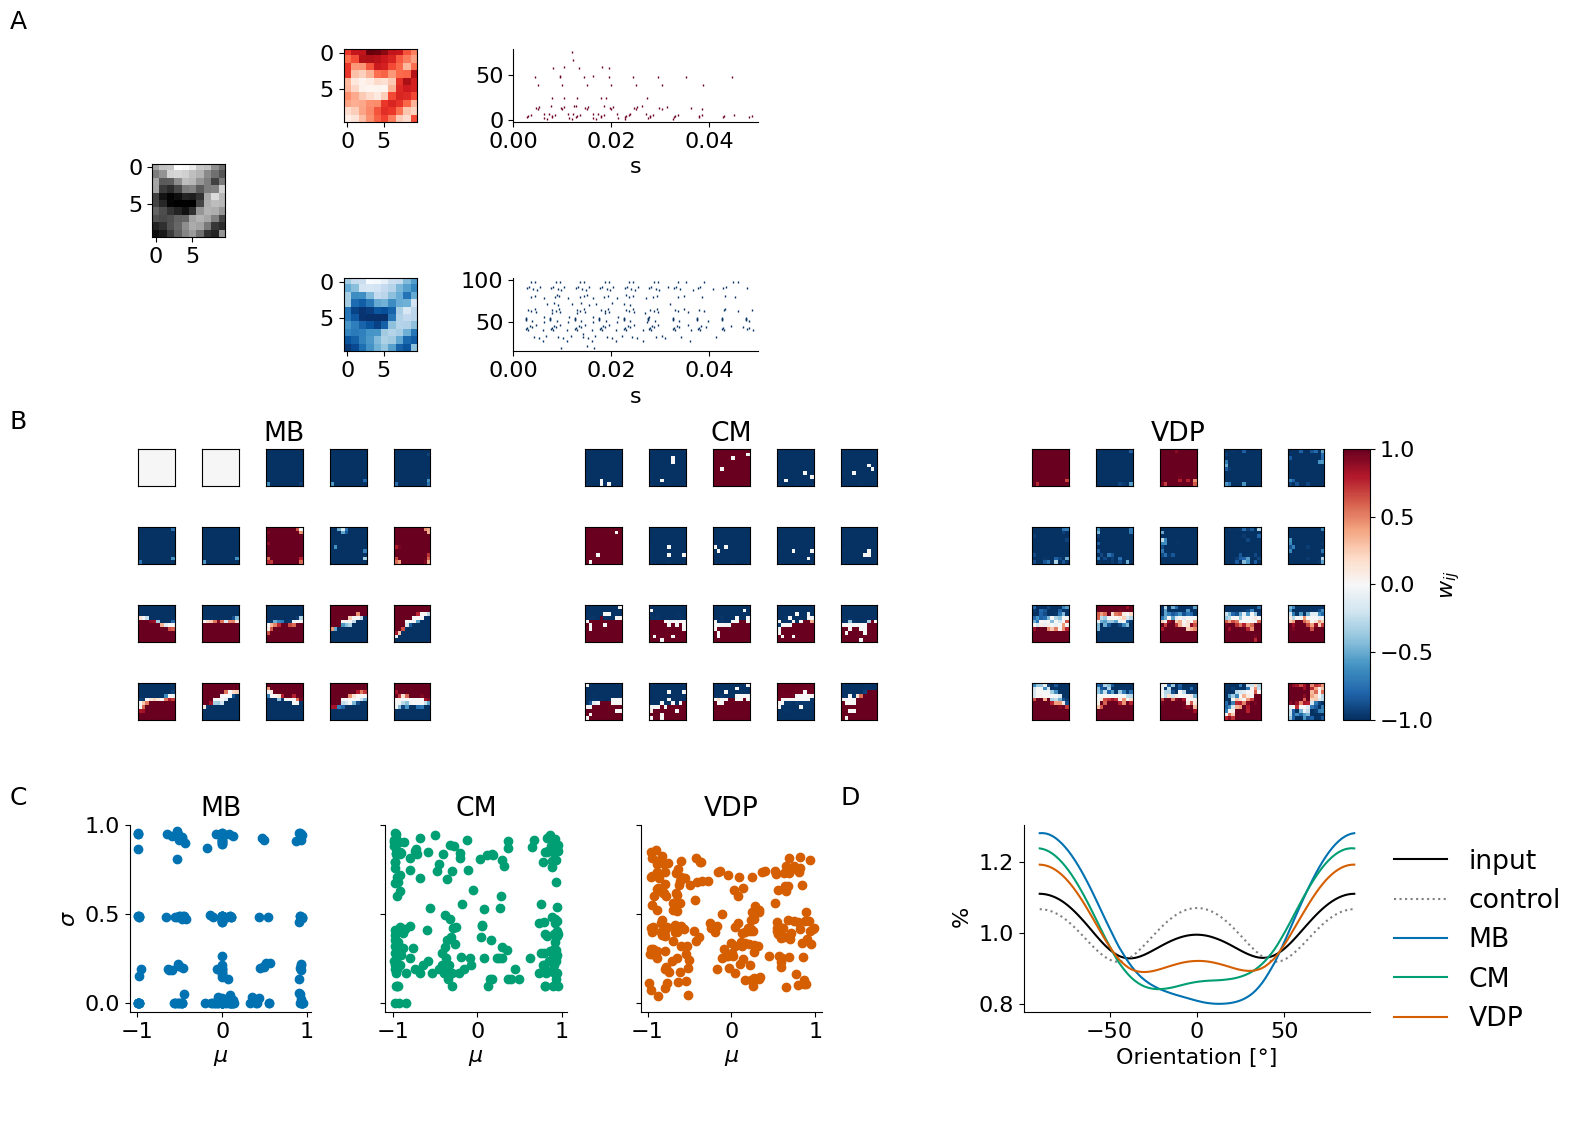

In [70]:
orientations = np.linspace(-90,90,100)

#continue to fix plotting here so it is acurate and shows the correct stuff

palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

layout = '''
    AAAAAAAAAAAAAAAAAAAA
    AAAAAAAAAAAAAAAAAAAA
    AAAAAAAAAAAAAAAAAAAA
    AAAAAAAAAAAAAAAAAAAA
    BBBBBBBBBBBBBBBBBBBB
    BBBBBBBBBBBBBBBBBBBB
    BBBBBBBBBBBBBBBBBBBB
    BBBBBBBBBBBBBBBBBBBB
    BBBBBBBBBBBBBBBBBBBB
    CCCCCCCCCCCCCDDDDDDD
    CCCCCCCCCCCCCDDDDDDD
    CCCCCCCCCCCCCDDDDDDD
    
    '''

fig = plt.figure(figsize=(16, 14))

height_ratios = [1,1,1,.2, 0.5,.5, .5,.5,0.3, 1,1, 1]
width_ratios = [0.2, 0.2, 0.2,0.2,0.2,.2, .2,.2,.2,.2,0.2, 0.2, 0.2,0.2,0.2,.2, .2,.2,.2,.1]


specs, gs = panel_specs(layout, fig=fig)
gs.set_height_ratios(height_ratios)
gs.set_width_ratios(width_ratios)
gs.hspace=0.8
axes = {}
for letter in 'ABCD':
    axes[letter] = ax = fig.add_subplot(specs[letter])
label_panels(axes, letters='ABCD', postfix='', offset_left=1.2)
for a in list('ABCD'):
    axes[a].set_axis_off()
    

#plot input specification

ax = fig.add_subplot(gs[1,0:2])
#plot one patch as it appears
images = np.load('receptive_fields/cifar_patches_10x10_zca.npz')['images']
images = images - images.mean()
ax.imshow(images[0],cmap=plt.cm.gray)

ax = fig.add_subplot(gs[0,3:5])
#plot on copy
ax.imshow(images[0] * 1, cmap = plt.cm.Reds)
ax = fig.add_subplot(gs[0,6:10])
ax.plot(spike_monitor_IG1.t / second, spike_monitor_IG1.i, "|",color = '#69001fff', ms=2)
ax.set_xlim(0,0.05)
ax.set_xlabel('s')
clear_axes(ax)

#plot off copy
ax = fig.add_subplot(gs[2,3:5])
ax.imshow(-images[0] *1, cmap = plt.cm.Blues)
ax = fig.add_subplot(gs[2,6:10])
ax.plot(spike_monitor_IG2.t / second, spike_monitor_IG2.i, "|",color = '#063263ff', ms=2)
ax.set_xlim(0,0.05)
ax.set_xlabel('s')
clear_axes(ax)

wmin = -1
wmax = 1

ind_to_plot_mb =np.linspace(0,40,20, dtype = int)
ind_to_plot_mb[:10] = np.arange(65,75,1, dtype = int)
ind_to_plot_mb[0] = 0
ind_to_plot_mb[1] = 1
#plot the sorted and reconstructed recptive fields for all models
for j in range(5): 
    for i in range(4): 
        ax = fig.add_subplot(gs[4+i,j])
        if i <2: 
            ax.imshow(mb_rf_w[ind_to_plot_mb[5*i+j]], vmin = wmin, vmax = wmax, cmap='RdBu_r')
        if i >= 2: 
            ax.imshow(mb_rf_w[-ind_to_plot_mb[5*i+j]], vmin = wmin, vmax = wmax, cmap='RdBu_r')
        ax.set_xticks(())
        ax.set_yticks(())
        if j == 2 and i ==0: 
            ax.set_title('MB')


for j in range(5): 
    for i in range(4): 
        ax = fig.add_subplot(gs[4+i,7+j])
        if i <2: 
            ax.imshow(cl_rf_w[5*i+j+20], vmin = wmin, vmax = wmax, cmap='RdBu_r')
        if i >= 2: 
            ax.imshow(cl_rf_w[-(5*i+j)], vmin = wmin, vmax = wmax, cmap='RdBu_r')
        ax.set_xticks(())
        ax.set_yticks(())
        if j == 2 and i ==0: 
            ax.set_title('CM')
            
for j in range(5): 
    for i in range(4): 
        ax = fig.add_subplot(gs[4+i,14+j])
        if i <2: 
            surf = ax.imshow(vdp_rf_w[5*i+j], vmin = wmin, vmax = wmax, cmap='RdBu_r')
        if i >= 2: 
            surf = ax.imshow(vdp_rf_w[-(5*i+j)], vmin = wmin, vmax = wmax, cmap='RdBu_r')
        ax.set_xticks(())
        ax.set_yticks(())
        if j == 2 and i ==0: 
            ax.set_title('VDP')
            
ax_cbar = fig.add_subplot(gs[4:8,19])
cbar = fig.colorbar(surf, ax_cbar, shrink=0.5, aspect=10)
cbar.ax.set_ylabel('$w_{ij}$')


#plot the mean and sds to characterise the receptive fields better 
#ax_m = fig.add_subplot(gs[9:11, 0:5])
ax = fig.add_subplot(gs[9:11, 0:3])
#ax_m.hist(mean_mb, bins = 50, density = True, color = palette[0], ec = 'white', linewidth = 0.00)
ax.scatter(mean_mb, sd_mb, color = palette[0])
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
clear_axes(ax)
ax.set_ylim(-0.05,1.0)
ax.set_title('MB')

#ax_s = fig.add_subplot(gs[9:11, 6:11])
#ax_s.hist(sd_mb, bins = 50, density = True, color = palette[0], ec = 'white', linewidth = 0.00, label = 'MB')
#ax_s.set_xlabel('$\sigma$')



#plot the mean and sds to characterise the receptive fields better 
ax = fig.add_subplot(gs[9:11, 4:7])
#ax_m.hist(mean_cl, bins = 50, density = True, color = palette[1], ec = 'white', linewidth = 0.00, alpha = 0.75)
ax.scatter(mean_cl, sd_cl, color = palette[1])
#ax_s.hist(sd_cl, bins = 50, density = True, color = palette[1], ec = 'white', linewidth = 0.00, label = 'CM', alpha = 0.75)
clear_axes(ax)
ax.set_xlabel('$\mu$')
#ax.set_ylabel('$\sigma$')
ax.set_ylim(-0.05,1.0)
ax.set_yticklabels([])
ax.set_title('CM')


#plot the mean and sds to characterise the receptive fields better 
ax = fig.add_subplot(gs[9:11, 8:11])
ax.scatter(mean_vdp, sd_vdp, color = palette[2])
clear_axes(ax)
ax.set_xlabel('$\mu$')
#ax.set_ylabel('$\sigma$')
ax.set_ylim(-0.05,1.0)
ax.set_yticklabels([])
ax.set_title('VDP')
#ax_m.hist(mean_vdp, bins = 50, density = True, color = palette[2], ec = 'white', linewidth = 0.00, alpha = 0.5)
#clear_axes(ax_m)
#ax_s.hist(sd_vdp, bins = 50, density = True, color = palette[2], ec = 'white', linewidth = 0.00, label = 'VDP', alpha = 0.5)
#clear_axes(ax_s)


ax = fig.add_subplot(gs[9:11, 14:20])
ax.errorbar(np.linspace(-90,90,orientations.shape[0]), scaled_im_stats*100,  color = 'k', label = 'input')#yerr = images_stats[0,:,1],
ax.errorbar(np.linspace(-90,90,orientations.shape[0]), scaled_control*100,color = 'grey', linestyle = ':', label = 'control')# yerr = control_stats[0,:,1], 
ax.errorbar(np.linspace(-90,90,orientations.shape[0]), scaled_mb_f*100, color = palette[0], label = 'MB') #yerr = mb_filter_stats[0,:,1], color = palette[0])
ax.errorbar(np.linspace(-90,90,orientations.shape[0]), scaled_cl_f*100, color = palette[1], label = 'CM') #yerr = cl_filter_stats[0,:,1]
ax.errorbar(np.linspace(-90,90,orientations.shape[0]), scaled_vdp_f*100,color = palette[2], label = 'VDP')# yerr = vdp_filter_stats[0,:,1], 
ax.legend( bbox_to_anchor=(1.0, 1.0), loc='upper left',  frameon = False)
ax.set_xlabel('Orientation [°]')
ax.set_ylabel('$\%$')
ax.set_xlabel('Orientation [°]')
ax.legend( bbox_to_anchor=(1.0, 1.0), loc='upper left',  frameon = False)
clear_axes(ax)
        


plt.savefig(figures_path+'fig6_receptive_fields.pdf', bbox_inches='tight')
plt.show()

In [76]:
#appendix figure for this with similairty measurement and the clustering analyses
from scipy.stats import ttest_rel
from sklearn.metrics.pairwise import cosine_similarity

def within_network_similarity(rfs):
    sim_scores = np.zeros([rfs.shape[0], rfs.shape[0]-1])
    for i in range(rfs.shape[0]): 
        for j in range(rfs.shape[0]): 
            if i != j: 
                if j > i : 
                    sim_scores[i,j-1] = cosine_similarity(rfs[i].reshape(1,-1), rfs[j].reshape(1,-1))
                else: 
                    sim_scores[i,j] = cosine_similarity(rfs[i].reshape(1,-1), rfs[j].reshape(1,-1))
                    
    return sim_scores
    
def reshuffle_stats(mus, sds): 
    stats = np.zeros([mus.shape[0],2])
    shuffled = np.zeros([mus.shape[0],2])
    stats[:,0] = mus[:]
    stats[:,1] = sds[:]
    
    np.random.shuffle(mus)
    np.random.shuffle(sds)
    shuffled[:,0] = mus[:]
    shuffled[:,1] = sds[:]
    
    return stats, shuffled, ttest_rel(stats, shuffled)



mb_sc = within_network_similarity(mb_rf_w)
cl_sc = within_network_similarity(cl_rf_w)
vdp_sc = within_network_similarity(vdp_rf_w)

borders = np.array([0.25,.5,.75,1.0])
mb_ind = np.zeros([borders.shape[0]+1])
cl_ind = np.zeros([borders.shape[0]+1])
vdp_ind = np.zeros([borders.shape[0]+1])
for i in range(borders.shape[0]): 
    mb_ind[i+1] = np.nonzero(sd_mb <= borders[i])[0][-1]
    cl_ind[i+1] = np.nonzero(sd_cl <= borders[i])[0][-1]
    vdp_ind[i+1] = np.nonzero(sd_vdp <= borders[i])[0][-1]


In [78]:
true_mb, resh_mb, ttest_mb = reshuffle_stats(mean_mb, sd_mb)
true_cl,resh_cl, ttest_cl = reshuffle_stats(mean_cl, sd_cl)
true_vdp,resh_vdp, ttest_vdp = reshuffle_stats(mean_vdp, sd_vdp)

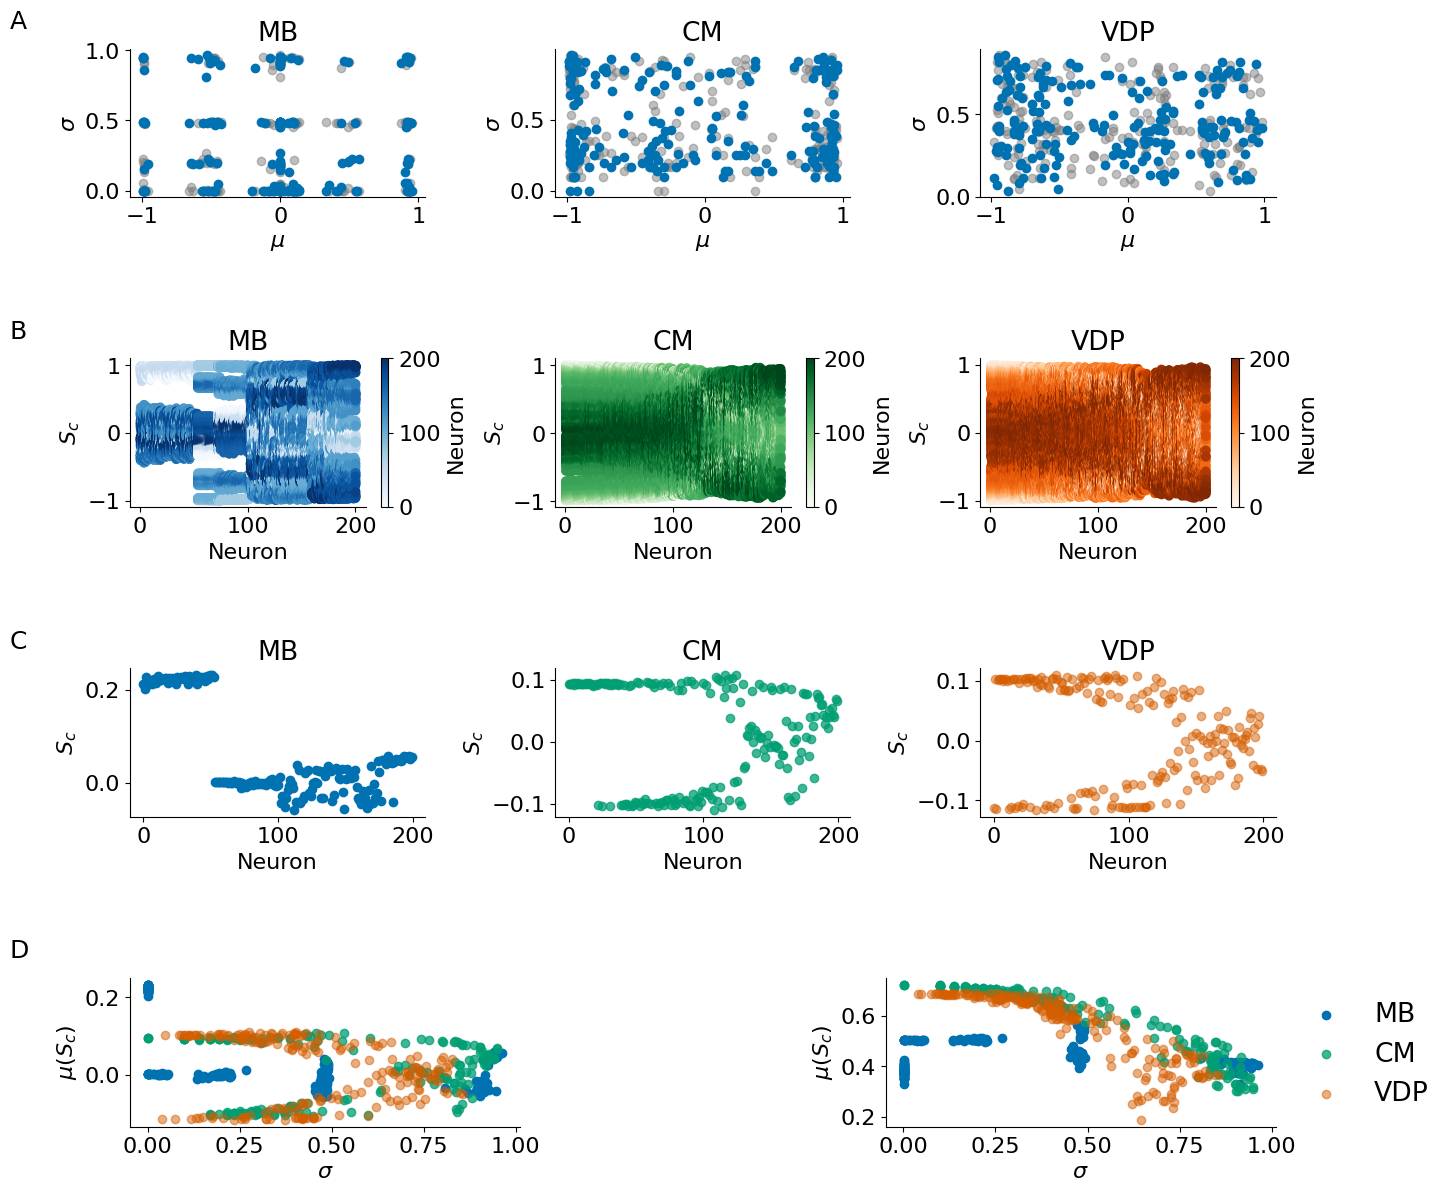

In [136]:
layout = '''
    AAAAAA
    AAAAAA
    BBBBBB
    BBBBBB
    CCCCCC
    CCCCCC
    DDDDDD
    '''

fig = plt.figure(figsize=(16, 14))

height_ratios = [1,0.1,1,0.1,1,0.1,1]
width_ratios = [1,0.2,1,0.2,1,0.2]


specs, gs = panel_specs(layout, fig=fig)
gs.set_height_ratios(height_ratios)
gs.set_width_ratios(width_ratios)
gs.hspace=0.8
axes = {}
for letter in 'ABCD':
    axes[letter] = ax = fig.add_subplot(specs[letter])
label_panels(axes, letters='ABCD', postfix='', offset_left=1.2)
for a in list('ABCD'):
    axes[a].set_axis_off()
    

#plot input specification

ax = fig.add_subplot(gs[0,0])
ax.scatter(resh_mb[:,0], resh_mb[:,1], color = 'grey', alpha = 0.5)
ax.scatter(true_mb[:,0], true_mb[:,1])

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_title('MB')
clear_axes(ax)

ax = fig.add_subplot(gs[0,2])
ax.scatter(resh_cl[:,0], resh_cl[:,1], color = 'grey', alpha = 0.5)
ax.scatter(true_cl[:,0], true_cl[:,1])

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_title('CM')
clear_axes(ax)

ax = fig.add_subplot(gs[0,4])
ax.scatter(resh_vdp[:,0], resh_vdp[:,1], color = 'grey', alpha = 0.5)
ax.scatter(true_vdp[:,0], true_vdp[:,1])

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_title('VDP')
clear_axes(ax)
########################################
shade = np.linspace(0.05,1,true_mb.shape[0]-1)

ax = fig.add_subplot(gs[2,0])
for i in range(mb_sc.shape[0]): 
    sc=ax.scatter(np.zeros([mb_sc.shape[0]-1])+i+1, mb_sc[i,:], c = np.linspace(-1,1,true_mb.shape[0]-1), cmap = 'Blues')
ax.set_xlabel('Neuron')
ax.set_ylabel('$S_c$')
ax.set_title('MB')
clear_axes(ax)

cbar = fig.colorbar(sc,ticks = [-1, 0, 1] )
cbar.ax.set_yticklabels(['0', '100', '200'])
cbar.ax.set_ylabel('Neuron')

ax = fig.add_subplot(gs[2,2])
for i in range(cl_sc.shape[0]): 
    sc=ax.scatter(np.zeros([cl_sc.shape[0]-1])+i+1, cl_sc[i,:], c = np.linspace(-1,1,true_cl.shape[0]-1), cmap = 'Greens')
ax.set_title('CM')
ax.set_xlabel('Neuron')
ax.set_ylabel('$S_c$')
clear_axes(ax)
cbar = fig.colorbar(sc,ticks = [-1, 0, 1] )
cbar.ax.set_yticklabels(['0', '100', '200'])
cbar.ax.set_ylabel('Neuron')

ax = fig.add_subplot(gs[2,4])
for i in range(vdp_sc.shape[0]): 
    sc=ax.scatter(np.zeros([vdp_sc.shape[0]-1])+i+1, vdp_sc[i,:], c = np.linspace(-1,1,true_vdp.shape[0]-1), cmap = 'Oranges')

ax.set_xlabel('Neuron')
ax.set_ylabel('$S_c$')
ax.set_title('VDP')
clear_axes(ax)
cbar = fig.colorbar(sc,ticks = [-1, 0, 1] )
cbar.ax.set_yticklabels(['0', '100', '200'])
cbar.ax.set_ylabel('Neuron')


########################################

ax = fig.add_subplot(gs[4,0])
ax.scatter(np.arange(0,mb_sc.shape[0]),np.mean(mb_sc, axis = 1), color = palette[0], alpha = 1)
ax.set_xlabel('Neuron')
ax.set_ylabel('$S_c$')
#ax.set_xlim(-0.2,0.2)
ax.set_title('MB')
clear_axes(ax)

ax = fig.add_subplot(gs[4,2])
ax.scatter(np.arange(0,cl_sc.shape[0]),np.mean(cl_sc, axis = 1), color = palette[1], alpha = 0.75)
ax.set_xlabel('Neuron')
ax.set_ylabel('$S_c$')
#ax.set_xlim(-0.2,0.2)
ax.set_title('CM')
clear_axes(ax)

ax = fig.add_subplot(gs[4,4])
ax.scatter(np.arange(0,vdp_sc.shape[0]),np.mean(vdp_sc, axis = 1), color = palette[2], alpha = 0.5)
ax.set_xlabel('Neuron')
ax.set_ylabel('$S_c$')
#ax.set_xlim(-0.2,0.2)
ax.set_title('VDP')
clear_axes(ax)

ax = fig.add_subplot(gs[6,0:2])
ax.scatter(true_mb[:,1], np.mean(mb_sc, axis = 1), color = palette[0], label = 'MB', alpha = 1)
ax.scatter(true_cl[:,1],np.mean(cl_sc, axis = 1), color = palette[1], label = 'CM', alpha = 0.75)
ax.scatter(true_vdp[:,1],np.mean(vdp_sc, axis = 1), color = palette[2], label = 'VDP', alpha = 0.5)
ax.set_xlabel('$\sigma$')
ax.set_ylabel('$\mu(S_c)$')
clear_axes(ax)

ax = fig.add_subplot(gs[6,3:5])
ax.scatter(true_mb[:,1], np.mean(np.abs(mb_sc), axis = 1), color = palette[0], label = 'MB', alpha = 1)
ax.scatter(true_cl[:,1],np.mean(np.abs(cl_sc), axis = 1), color = palette[1], label = 'CM', alpha = 0.75)
ax.scatter(true_vdp[:,1],np.mean(np.abs(vdp_sc), axis = 1), color = palette[2], label = 'VDP', alpha = 0.5)
ax.legend( bbox_to_anchor=(1.0, 1.0), loc='upper left',  frameon = False)
ax.set_xlabel('$\sigma$')
ax.set_ylabel('$\mu(S_c)$')
clear_axes(ax)
#plt.savefig(figures_path+'appendix_receptive_fields_fig.pdf', bbox_inches='tight')
plt.show()

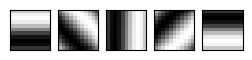

In [10]:
x = np.tile(np.arange(-5,6),(11,1)) #tiling of the space, also the size of the kernel
y = x.T 
sd = 3 #standard deviation of the gaussian
#orientations = np.linspace(0,1,100)  #orientations of the filter, this is a ratio of x and y contribution in the sine function
orientations = np.linspace(-90,90,100)
rotations = [0,30,45,60,90]  #rotations of the images and rfs for testing against aliasing

#calculating the Gabor patches with teo different spatial frequencies and several orientations
kernel_dict= np.zeros([orientations.shape[0],len(x), len(x)])
for i in range(orientations.shape[0]): 
    kernel_dict[-i-1] = np.cos(-2 * np.pi * .08 * np.cos(np.deg2rad(orientations[i])) * x+ 2 * np.pi * .08 * np.sin(np.deg2rad(orientations[i])) * y+ 1/2 * np.pi)

sub_sample_for_figure = np.array([0,25,50,75,-1])
fig,ax = plt.subplots(1,sub_sample_for_figure.shape[0], figsize = (3,10))
for ind,i in enumerate(sub_sample_for_figure):
    ax[ind].imshow(kernel_dict[i], cmap = 'grey')
    ax[ind].set_yticks([])
    ax[ind].set_xticks([])
plt.savefig('gabor_patches.pdf')
plt.show()